--- PARAMETERS ---
Roll No: 102483081
Calculated: a_r = 0.5, b_r = 0.6
------------------

--- LOADING DATA ---


/tmp/ipython-input-344189095.py:49: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_to_load, encoding='ISO-8859-1')


Dataset loaded successfully!
Using column: 'no2'
Note: Truncated data to first 50,000 samples for speed.
Data ready. Training on 50000 samples.

Starting Training (Progress will print every epoch)...
Epoch [1/20] | D Loss: 1.3911 | G Loss: 0.6891
Epoch [2/20] | D Loss: 1.3846 | G Loss: 0.6868
Epoch [3/20] | D Loss: 1.3740 | G Loss: 0.6912
Epoch [4/20] | D Loss: 1.3687 | G Loss: 0.7000
Epoch [5/20] | D Loss: 1.3652 | G Loss: 0.7064
Epoch [6/20] | D Loss: 1.3560 | G Loss: 0.7136
Epoch [7/20] | D Loss: 1.3487 | G Loss: 0.7239
Epoch [8/20] | D Loss: 1.3401 | G Loss: 0.7336
Epoch [9/20] | D Loss: 1.3424 | G Loss: 0.7255
Epoch [10/20] | D Loss: 1.3617 | G Loss: 0.7049
Epoch [11/20] | D Loss: 1.3819 | G Loss: 0.6917
Epoch [12/20] | D Loss: 1.3845 | G Loss: 0.6829
Epoch [13/20] | D Loss: 1.3899 | G Loss: 0.6842
Epoch [14/20] | D Loss: 1.4100 | G Loss: 0.6804
Epoch [15/20] | D Loss: 1.4383 | G Loss: 0.6809
Epoch [16/20] | D Loss: 1.4340 | G Loss: 0.6850
Epoch [17/20] | D Loss: 1.4074 | G Loss: 

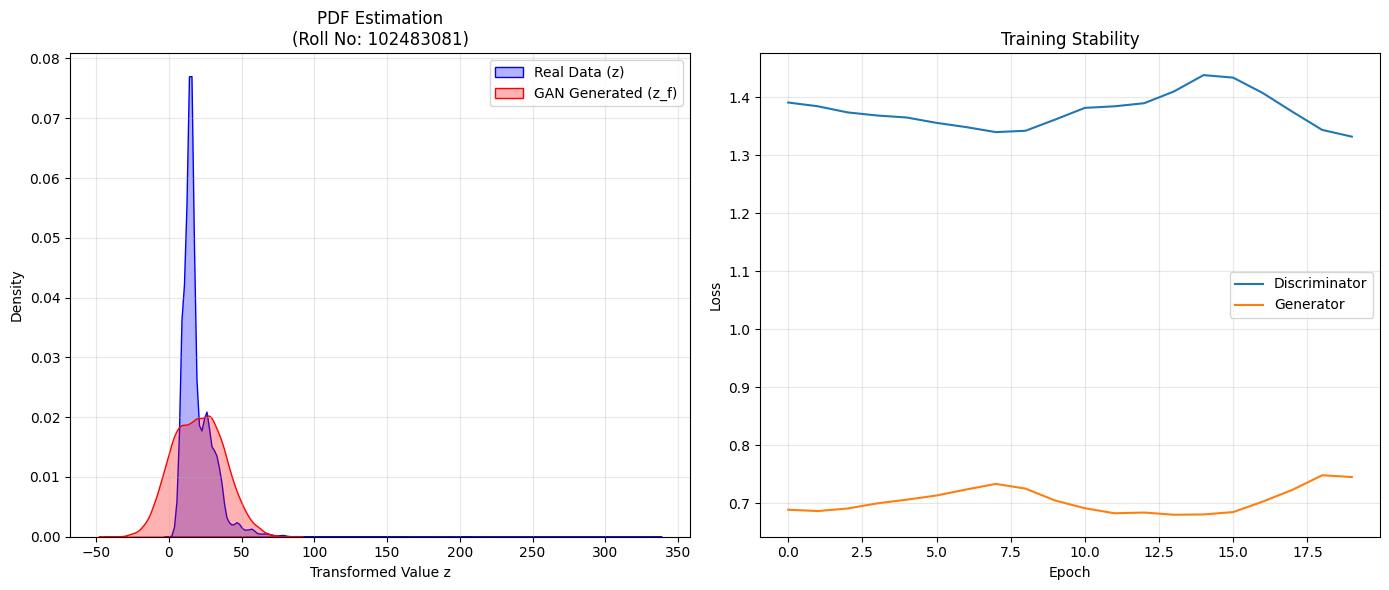

Execution Complete.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# ==========================================
# 1. SETUP AND PARAMETERS (OPTIMIZED)
# ==========================================
ROLL_NUMBER = 102483081
BATCH_SIZE = 2048     # INCREASED: Processes more data at once (faster)
LR = 0.0002
EPOCHS = 20           # REDUCED: 20 is enough for this large dataset
NOISE_DIM = 5

# Calculate Parameters
r_mod_7 = ROLL_NUMBER % 7
r_mod_5 = ROLL_NUMBER % 5

a_r = 0.5 * r_mod_7
b_r = 0.3 * (r_mod_5 + 1)

print(f"--- PARAMETERS ---")
print(f"Roll No: {ROLL_NUMBER}")
print(f"Calculated: a_r = {a_r}, b_r = {b_r}")
print("------------------\n")

# ==========================================
# 2. DATA LOADING
# ==========================================
print("--- LOADING DATA ---")

file_to_load = None
if os.path.exists('data.csv'): file_to_load = 'data.csv'
elif os.path.exists('city_day.csv'): file_to_load = 'city_day.csv'
elif os.path.exists('archive (1).zip'):
    with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
        zip_ref.extractall()
    if os.path.exists('data.csv'): file_to_load = 'data.csv'
    elif os.path.exists('city_day.csv'): file_to_load = 'city_day.csv'

if file_to_load:
    try:
        df = pd.read_csv(file_to_load, encoding='ISO-8859-1')
    except:
        df = pd.read_csv(file_to_load, encoding='cp1252')
    print("Dataset loaded successfully!")
else:
    raise FileNotFoundError("Could not find data file.")

# ==========================================
# 3. PRE-PROCESSING
# ==========================================
# Handle case sensitivity
target_col = 'no2' if 'no2' in df.columns else 'NO2'
if target_col not in df.columns:
    df.columns = df.columns.str.strip() # clean spaces
    target_col = 'no2' if 'no2' in df.columns else 'NO2'

print(f"Using column: '{target_col}'")
data = df[target_col].dropna().values

# Clean non-numeric data
data = pd.to_numeric(data, errors='coerce')
data = data[~np.isnan(data)]
x = data.astype(np.float32)

# Limit dataset size if it's too huge (Optional, but helps speed)
# If you want to use ALL data, comment out the next 2 lines
if len(x) > 50000:
    x = x[:50000]
    print("Note: Truncated data to first 50,000 samples for speed.")

# Apply Transformation
z = x + a_r * np.sin(b_r * x)

# Standardization
z_mean = np.mean(z)
z_std = np.std(z)
z_scaled = (z - z_mean) / z_std

# Create DataLoader
real_data_tensor = torch.tensor(z_scaled.reshape(-1, 1), dtype=torch.float32)
dataset = TensorDataset(real_data_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Data ready. Training on {len(z)} samples.")

# ==========================================
# 4. GAN ARCHITECTURE
# ==========================================
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(NOISE_DIM, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

generator = Generator()
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=LR)
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR)
criterion = nn.BCELoss()

# ==========================================
# 5. TRAINING LOOP
# ==========================================
print("\nStarting Training (Progress will print every epoch)...")
loss_g_history = []
loss_d_history = []

for epoch in range(EPOCHS):
    for i, (real_samples,) in enumerate(dataloader):
        batch_size = real_samples.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs_real = discriminator(real_samples)
        d_loss_real = criterion(outputs_real, real_labels)

        z_noise = torch.randn(batch_size, NOISE_DIM)
        fake_samples = generator(z_noise)
        outputs_fake = discriminator(fake_samples.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs_generated = discriminator(fake_samples)
        g_loss = criterion(outputs_generated, real_labels)
        g_loss.backward()
        optimizer_G.step()

    loss_g_history.append(g_loss.item())
    loss_d_history.append(d_loss.item())

    # Print EVERY epoch so you see it moving
    print(f"Epoch [{epoch+1}/{EPOCHS}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# ==========================================
# 6. VISUALIZATION
# ==========================================
print("\nTraining Complete. Generating Graphs...")
with torch.no_grad():
    z_noise_vis = torch.randn(len(z), NOISE_DIM)
    generated_data_scaled = generator(z_noise_vis).numpy()

generated_data = (generated_data_scaled * z_std) + z_mean
real_data_unscaled = z

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(real_data_unscaled, label='Real Data (z)', fill=True, color='blue', alpha=0.3)
sns.kdeplot(generated_data.flatten(), label='GAN Generated (z_f)', fill=True, color='red', alpha=0.3)
plt.title(f'PDF Estimation\n(Roll No: {ROLL_NUMBER})')
plt.xlabel('Transformed Value z')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(loss_d_history, label='Discriminator')
plt.plot(loss_g_history, label='Generator')
plt.title('Training Stability')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Execution Complete.")